Source code obtained from https://github.com/AustinLBuchanan/Districting-Examples/tree/main/starters
This code has been modified from Oklahoma to fit Idaho
Credit to Austin Buchanan

In [3]:
from gerrychain import Graph

In [4]:
# Read Idaho county graph from the json file "ID_county.json"
filename = 'ID_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filename )

In [5]:
# Let's impose a population deviation ranging from 1% to 0.1% depending on user input
deviation = 0.01

import math
k = 2          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 779873 and U = 787709 and k = 2


In [6]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Academic license - for non-commercial use only - expires 2021-06-05
Using license file C:\Users\user\gurobi.lic


In [7]:
# objective is to minimize the total perimeter of the districts
#  the boundary length between counties u and v is stored in G.edges[u,v]['shared_perim']
m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim'] * y[u,v] for u,v in G.edges ) , GRB.MINIMIZE )

In [8]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [9]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [10]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()

In [11]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 488 rows, 482 columns and 1942 nonzeros
Model fingerprint: 0x0678229a
Variable types: 204 continuous, 278 integer (278 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [3e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 46 rows and 44 columns
Presolve time: 0.00s
Presolved: 442 rows, 438 columns, 1766 nonzeros
Variable types: 204 continuous, 234 integer (234 binary)

Root relaxation: objective 0.000000e+00, 121 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   48          -    0.00000      -     -    0s
     0     0    0.00000    0   52          -    0.00000      -     -    0s
     0     0    0.073

In [12]:
print("The total perimeter length (excluding the exterior boundary of state) is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The total perimeter length (excluding the exterior boundary of state) is 7.239443628867949
District 0 has population 786292 and contains counties ['Lewis', 'Idaho', 'Camas', 'Power', 'Bear Lake', 'Latah', 'Washington', 'Caribou', 'Clark', 'Lemhi', 'Fremont', 'Bonner', 'Bonneville', 'Minidoka', 'Boundary', 'Custer', 'Teton', 'Blaine', 'Jefferson', 'Nez Perce', 'Adams', 'Clearwater', 'Oneida', 'Valley', 'Kootenai', 'Benewah', 'Lincoln', 'Cassia', 'Franklin', 'Butte', 'Madison', 'Shoshone', 'Bingham', 'Bannock']
District 1 has population 781290 and contains counties ['Canyon', 'Gem', 'Twin Falls', 'Boise', 'Owyhee', 'Payette', 'Gooding', 'Jerome', 'Elmore', 'Ada']


In [13]:
# Let's draw it on a map
import geopandas as gpd

In [14]:
# Read Idaho county shapefile from "ID_counties.shp"
filename = 'ID_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filename )

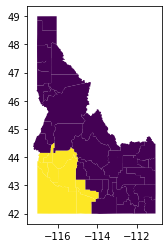

In [15]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()